In [80]:
"""Minimal QuSpin script for a 1D Bose–Hubbard chain
with N=6 sites, maximum on-site occupation sps=4 (0–3 bosons),
Np=N total bosons, and onsite interaction U plus nearest‑neighbour
hopping J.  Prints the ground‑state energy E0.
"""

import os
from numba import carray, cfunc, uint32, int32, float64
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb
from quspin.operators import hamiltonian
from quspin.basis.user import (
    user_basis,
    next_state_sig_32,
    op_sig_32,
    map_sig_32,
    count_particles_sig_32,
)

# ------------------------------------------------------------------
# Environment (needed on some macOS / MKL setups)
# ------------------------------------------------------------------
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [81]:
def simulate(N, sps, Np, J, U):
    # ------------------------------------------------------------------
    # 1) Operator acting on a single site
    # ------------------------------------------------------------------
    @cfunc(
        op_sig_32,
        locals=dict(b=uint32, occ=int32, sps=uint32, me_offdiag=float64, me_diag=float64),
    )
    def op(op_struct_ptr, op_str, site_ind, N, args):
        op_struct = carray(op_struct_ptr, 1)[0]
        err = 0
        sps = args[0]

        me_offdiag = 1.0
        me_diag = 1.0

        site_ind = N - site_ind - 1  # bit order → site index
        occ = (op_struct.state // sps**site_ind) % sps
        b = sps**site_ind

        if op_str == 43:  # '+'  (create)
            me_offdiag *= (occ + 1) % sps
            if (occ + 1) < sps:
                op_struct.state += b

        elif op_str == 45:  # '-'  (annihilate)
            me_offdiag *= occ
            if occ > 0:
                op_struct.state -= b

        elif op_str == 110:  # 'n'  (number)
            me_diag *= occ

        elif op_str == 73:  # 'I'  (identity)
            pass

        else:  # anything else: error
            me_diag = 0.0
            err = -1

        op_struct.matrix_ele *= me_diag * np.sqrt(me_offdiag)
        return err


    op_args = np.array([sps], dtype=np.uint32)


    # ------------------------------------------------------------------
    # 2) Particle-conserving iterator (next_state) and helpers
    # ------------------------------------------------------------------
    @cfunc(
        next_state_sig_32,
        locals=dict(
            t=uint32,
            i=int32,
            j=int32,
            n=int32,
            sps=uint32,
            b1=int32,
            b2=int32,
            l=int32,
            n_left=int32,
        ),
    )
    def next_state(s, counter, N, args):
        """
        Lexicographic iterator that yields the next basis state with fixed
        total particle number.  Based on the algorithm in the QuSpin docs.
        """
        t = s
        sps = args[1]
        n = 0  # running particle count

        for i in range(N):  # loop over sites
            b1 = (t // args[i]) % sps  # occupation on site i

            if b1 > 0:  # if site i has a boson
                n += b1
                b2 = (t // args[i + 1]) % sps  # *look one site ahead*

                if b2 < (sps - 1):  # can move a boson forward?
                    n -= 1
                    t -= args[i]  # remove boson from site i
                    t += args[i + 1]  # add boson to site i+1

                    if n > 0:
                        # fill earlier sites in lexicographic order
                        l = n // (sps - 1)
                        n_left = n % (sps - 1)

                        for j in range(i + 1):
                            t -= (t // args[j]) % sps * args[j]
                            if j < l:
                                t += (sps - 1) * args[j]
                            elif j == l:
                                t += n_left * args[j]
                    break
        return t


    # --- FIX: supply N+1 powers so args[i+1] is always defined ----------
    next_state_args = np.array([sps**i for i in range(N + 1)], dtype=np.uint32)
    # --------------------------------------------------------------------


    def get_s0_pcon(N, Np):
        """First integer representing a basis state with total Np particles."""
        l = Np // (sps - 1)
        s = sum((sps - 1) * sps**i for i in range(l))
        s += (Np % (sps - 1)) * sps**l
        return s


    def get_Ns_pcon(N, Np):
        """Number of states with Np particles *before* symmetry reductions."""
        Ns = 0
        for r in range(Np // sps + 1):
            r2 = Np - r * sps
            term = comb(N, r, exact=True) * comb(N + r2 - 1, r2, exact=True)
            Ns += term if (r % 2 == 0) else -term
        return Ns


    # ------------------------------------------------------------------
    # 3) Symmetry maps: translation and parity
    # ------------------------------------------------------------------
    @cfunc(
        map_sig_32,
        locals=dict(shift=uint32, out=uint32, sps=uint32, i=int32, j=int32),
    )
    def translation(x, N, sign_ptr, args):
        out = 0
        shift = args[0]
        sps = args[1]
        for i in range(N):
            j = (i + shift + N) % N
            out += (x % sps) * sps**j
            x //= sps
        return out


    T_args = np.array([1, sps], dtype=np.uint32)


    @cfunc(
        map_sig_32,
        locals=dict(out=uint32, sps=uint32, i=int32, j=int32),
    )
    def parity(x, N, sign_ptr, args):
        out = 0
        sps = args[0]
        for i in range(N):
            j = (N - 1) - i
            out += (x % sps) * sps**j
            x //= sps
        return out


    P_args = np.array([sps], dtype=np.uint32)


    # ------------------------------------------------------------------
    # 4) Particle-counting callback (required by user_basis)
    # ------------------------------------------------------------------
    @cfunc(
        count_particles_sig_32,
        locals=dict(s=uint32),
    )
    def count_particles(x, p_number_ptr, args):
        """Counts particles (occupation	≥ 1) in a basis state."""
        s = x
        for _ in range(args[0]):
            p_number_ptr[0] += s % args[1]
            s //= args[1]


    count_particles_args = np.array([N, sps], dtype=np.int32)
    n_sectors = 1  # only one conserved particle sector here

    # ------------------------------------------------------------------
    # 5) Assemble the user basis object
    # ------------------------------------------------------------------
    maps = dict(
        T_block=(translation, N, 0, T_args),
        P_block=(parity, 2, 0, P_args),
    )

    pcon_dict = dict(
        Np=Np,
        next_state=next_state,
        next_state_args=next_state_args,
        get_Ns_pcon=get_Ns_pcon,
        get_s0_pcon=get_s0_pcon,
        count_particles=count_particles,
        count_particles_args=count_particles_args,
        n_sectors=n_sectors,
    )

    op_dict = dict(op=op, op_args=op_args)

    basis = user_basis(
        np.uint32, N, op_dict, allowed_ops=set("+-nI"), sps=sps, pcon_dict=pcon_dict, **maps
    )

    # ------------------------------------------------------------------
    # 6) Built-in QuSpin boson basis for comparison
    # ------------------------------------------------------------------
    basis_1d = boson_basis_1d(
        N,
        Nb=Np,
        sps=sps,  # same Hilbert space
        kblock=0,
        pblock=1,  # momentum k=0, parity +1
    )

    # ------------------------------------------------------------------
    # 7) Bose-Hubbard Hamiltonian: hopping + onsite interaction
    # -----------------------------------------------------------------

    hopping = [[J, j, (j + 1) % N] for j in range(N)]
    int_bb = [[0.5 * U, j, j] for j in range(N)]
    int_b = [[-0.5 * U, j] for j in range(N)]

    static = [["+-", hopping], ["-+", hopping], ["nn", int_bb], ["n", int_b]]
    dynamic = []

    no_checks = dict(check_symm=False, check_pcon=False, check_herm=False)

    H = hamiltonian(static, dynamic, basis=basis, dtype=np.float64, **no_checks)
    return float(np.min(H.eigvalsh()))

In [84]:
def energy_sweep(N, sps, Nb, J):
    E = []
    for U in np.arange(2,5,0.2):
        E.append(simulate(N, sps, Nb, J, U))
    return np.array(E)

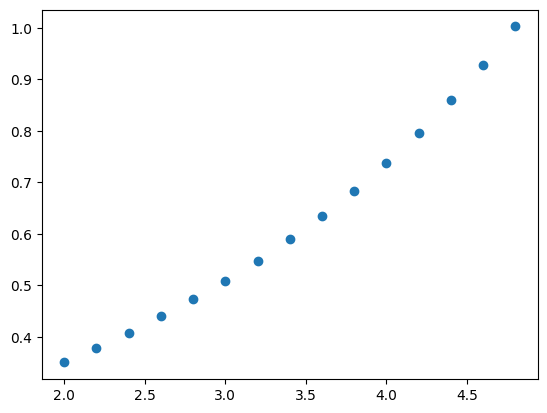

In [86]:
E0 = energy_sweep(N=6,sps=4,Nb=6,J=-1.0)
E_plus = energy_sweep(N=6,sps=4,Nb=7,J=-1.0)
E_minus = energy_sweep(N=6,sps=4,Nb=5,J=-1.0)

plt.scatter(np.arange(2,5,0.2),E_plus + E_minus - 2*E0)